In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import colormaps as cm
import os
import glob
import gaitFunctions
from gaitFunctions import swingTimingProportions
from scipy import stats
import seaborn as sns

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.4
marker_color = 'k'

In [3]:
# load data
excel_file = 'all_exemplaris_2024-04-03.xlsx'

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)

,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,NaN,0.667,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,NaN,1.030,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,NaN,0.879,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


# leg relationships and colors

In [4]:
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

# colors
all_leg_color = 'dimgrey'
L2_L1_color =   second_pair_color
L3_L2_color =   third_pair_color
R2_R1_color =   second_pair_color_alt
R3_R2_color =   third_pair_color_alt

# Suppression of simultaneous swings

All Legs - ipsilateral offsets: 5175 steps
All Legs - contralateral offsets: 3809 steps
-- ipsilateral -- 
L2 : 1301 steps
L3 : 1279 steps
R2 : 1317 steps
R3 : 1278 steps
-- contralateral -- 
L3 : 1253 steps
L2 : 1251 steps
L1 : 1305 steps
L4 : 1530 steps
R4 : 1532 steps
All legs - ipsilateral stance-swing offsets:  4571 steps
All legs - contralateral stance-swing offsets:  3548 steps
L2 : 1145 steps
L3 : 1145 steps
R2 : 1154 steps
R3 : 1127 steps
L3 : 1161 steps
L2 : 1184 steps
L1 : 1203 steps


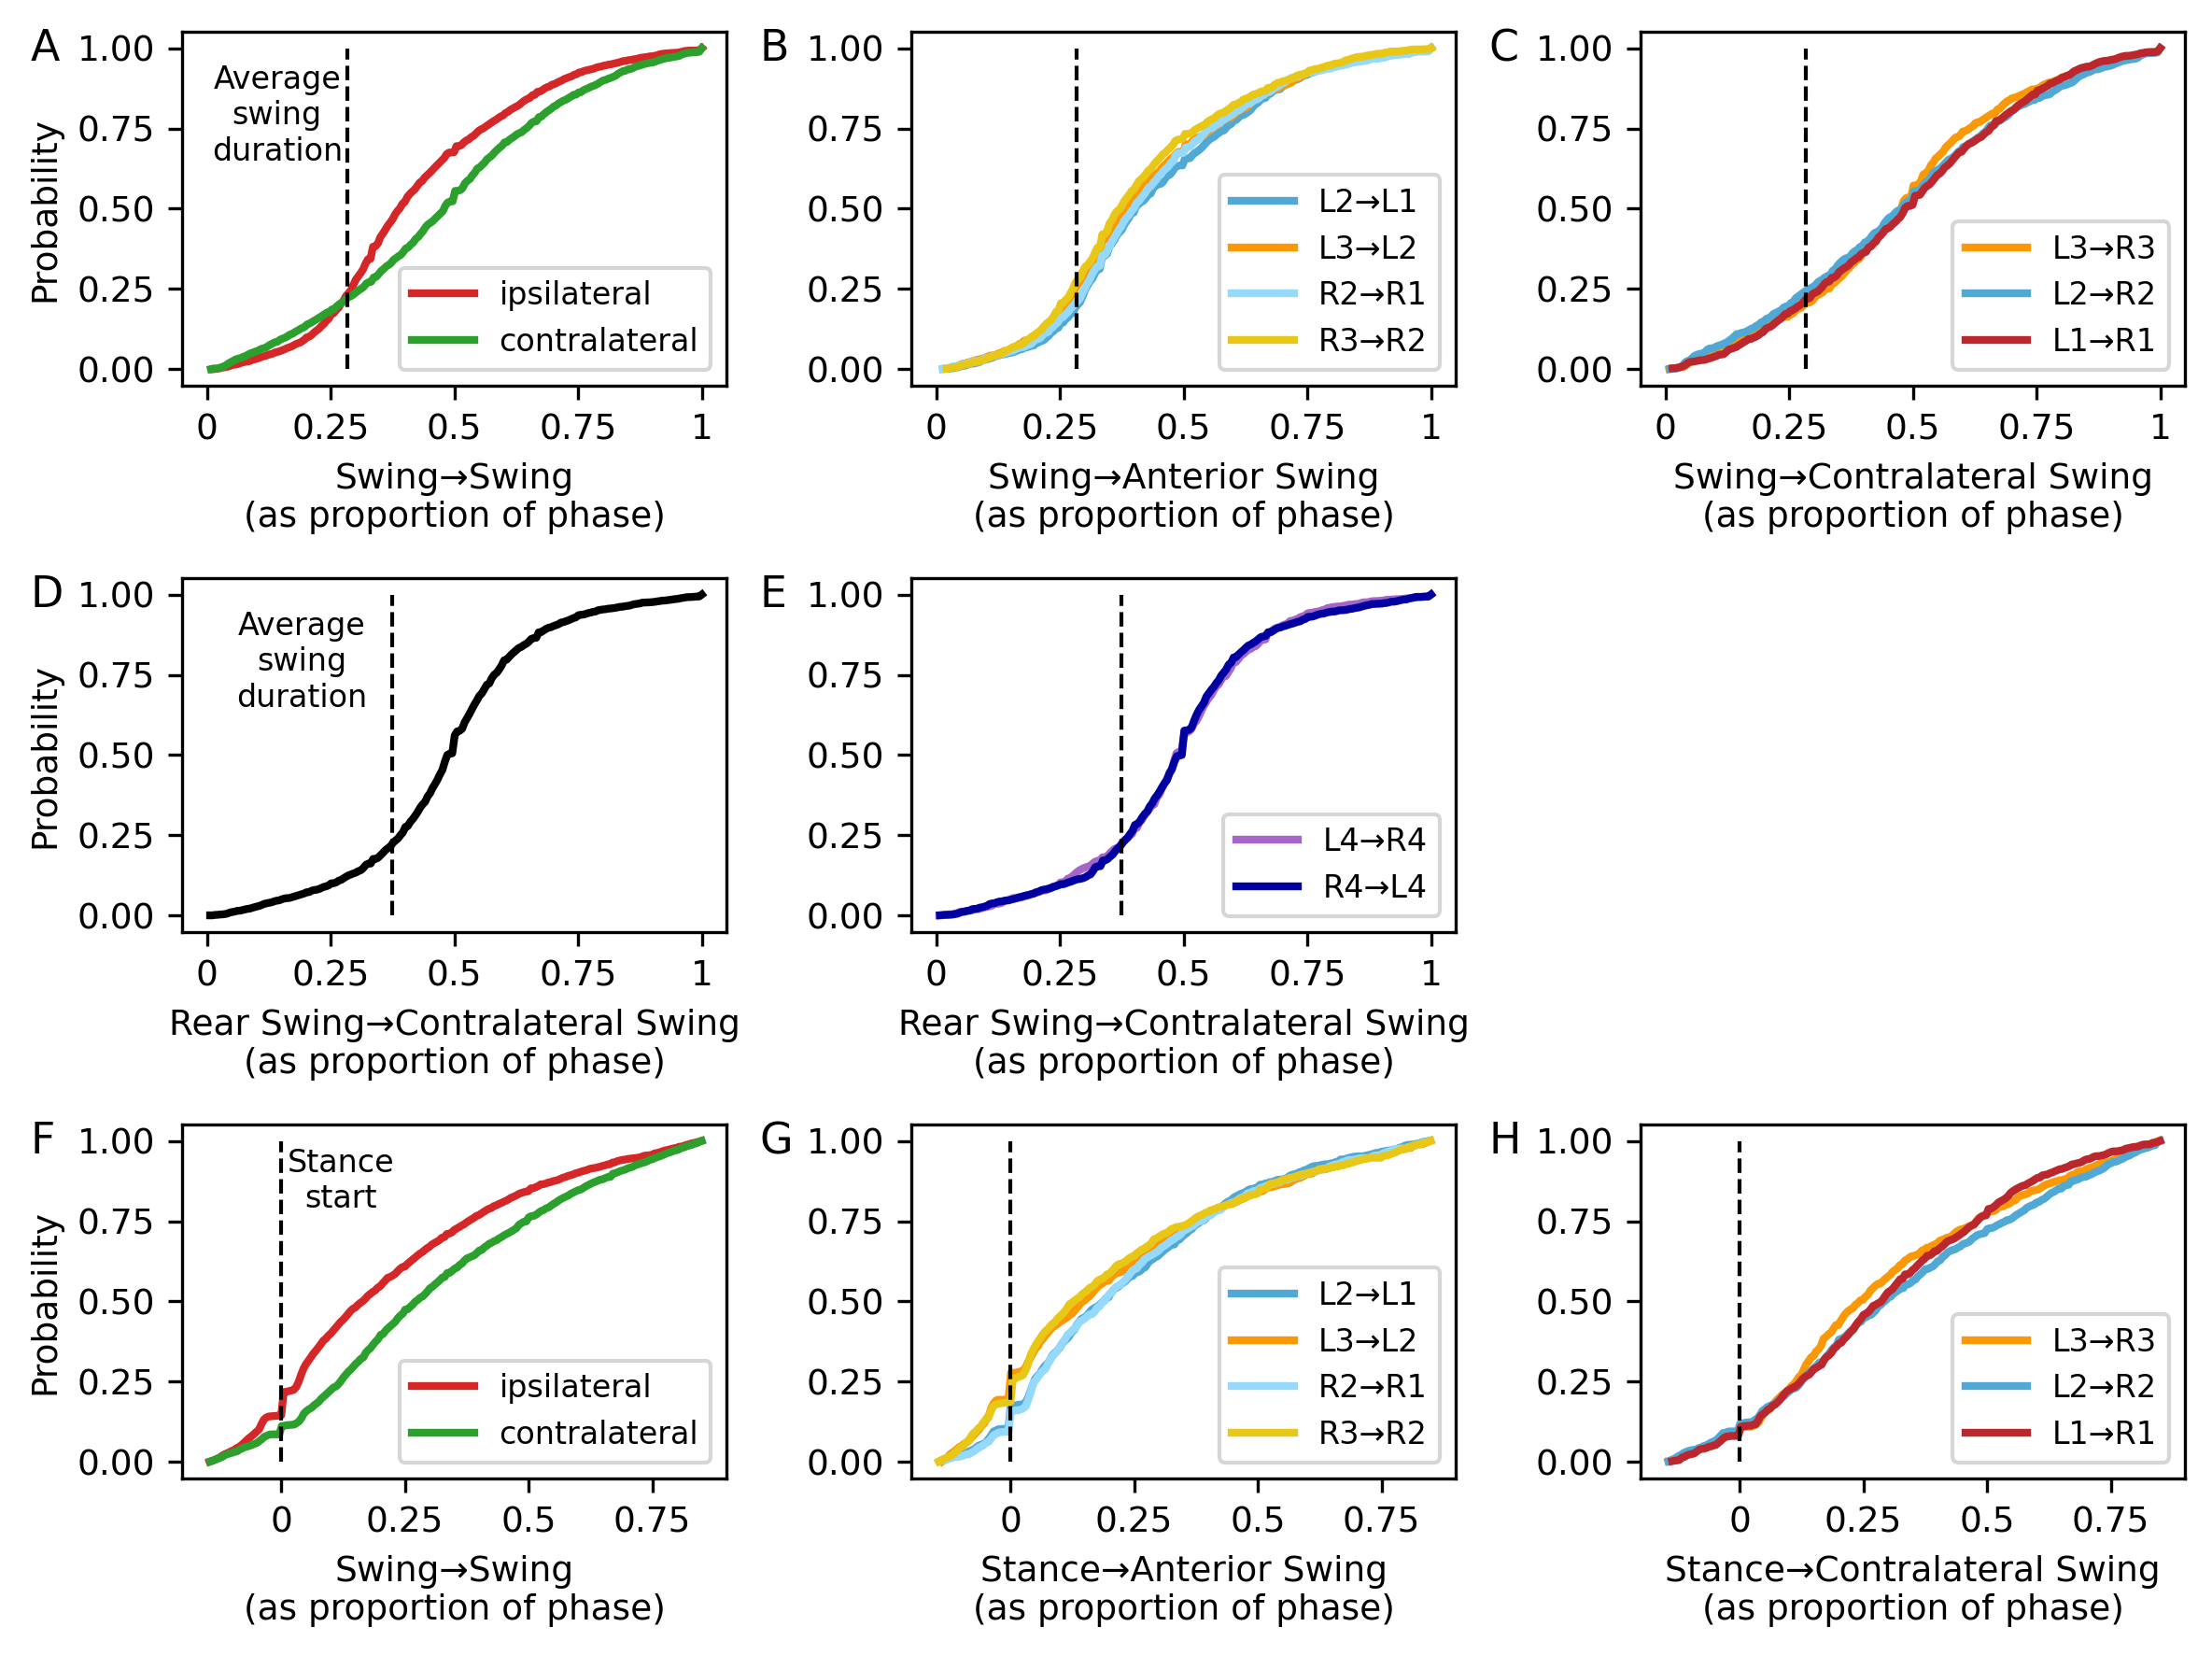

In [5]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]] = plt.subplots(3,3,figsize=(8,6), dpi=300)

### TOP LEFT AXIS
## all legs ... ipsilateral offsets
proportions = []
speeds = []
offsets = []
for leg in ipsi_offset_legs:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg, ipsi_legs[leg])

ipsi_swing_averages = np.mean(step_df[step_df.legID.isin(ipsi_offset_legs)].swing.values)
ipsi_period_averages = np.mean(step_df[step_df.legID.isin(ipsi_offset_legs)].gait.values)
normalized_ipsi_swing_averages = ipsi_swing_averages / ipsi_period_averages
    
# ----> plot cumulative probability
H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax1.plot(X1[1:], F1, linewidth=2, color = ipsi_color, label='ipsilateral')
print('All Legs - ipsilateral offsets:', len(proportions), 'steps')


## all legs ... contralateral offsets
proportions = []
speeds = []
offsets = []
for leg in left_laterals:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg, contra_legs[leg])

# ----> plot cumulative probability
H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax1.plot(X1[1:], F1, linewidth=2, color = contra_color, label='contralateral')
print('All Legs - contralateral offsets:', len(proportions), 'steps')
    
# labels and legend for LEFT axis
ax1.legend(fontsize=tick_fontsize-1)
ax1.set_xlabel('Swing→Swing\n(as proportion of phase)',fontsize=tick_fontsize)
ax1.set_ylabel('Probability',fontsize=tick_fontsize)
ax1.text(ipsi_swing_averages-0.13, 0.95,'Average\nswing\nduration', fontsize=tick_fontsize-1, 
         horizontalalignment='center', verticalalignment='top')
ax1.annotate('A', xy=(-0.28, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

### MIDDLE AXIS
## Individual Legs --> ipsilateral offsets ... 
print('-- ipsilateral -- ')
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]
ypos = 1
swing_averages = np.mean(step_df[step_df.legID.isin(ipsi_offset_legs)].swing.values)
for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, step_df, comp[0], comp[1])
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax2.plot(X1[1:], F1, linewidth=2, color = plot_cols[i], label='→'.join(comp))
    print(comp[0], ':', len(proportions), 'steps')
ax2.legend(fontsize=tick_fontsize-1)
ax2.set_xlabel('Swing→Anterior Swing\n(as proportion of phase)',fontsize=tick_fontsize)

### RIGHT AXIS
## Individual Legs --> contralateral offsets ... 
print('-- contralateral -- ')
leg_comps = [['L3','R3'],['L2','R2'],['L1','R1']]
plot_cols = [third_pair_color,second_pair_color,first_pair_color]

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, step_df, comp[0], comp[1])
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax3.plot(X1[1:], F1, linewidth=2, color = plot_cols[i], label='→'.join(comp))
    print(comp[0], ':', len(proportions), 'steps')
ax3.legend(fontsize=tick_fontsize-1)
ax3.set_xlabel('Swing→Contralateral Swing\n(as proportion of phase)',fontsize=tick_fontsize)

for ax in [ax1,ax2,ax3]:
    ax.plot([normalized_ipsi_swing_averages,normalized_ipsi_swing_averages],[0,1],'--k', linewidth=1)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    
### MIDDLE ROW! REAR CONTRALATERAL
proportions = []
speeds = []
offsets = []
contra_rear = {'L4':'R4','R4':'L4'}
for leg in ['L4','R4']:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, step_df, leg, 
                                                          contra_rear[leg])

rear_swing_averages = np.mean(step_df[step_df.legID.isin(['L4','R4'])].swing.values)

H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax4.plot(X1[1:], F1, linewidth=2, color = 'k', label='rear legs')

# seaborn kernel density estimation
# ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, cumulative=True,
#                   stat='probability',line_kws={'linewidth':5},
#                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars

leg_comps = [['L4','R4'],['R4','L4']]
plot_cols = [rear_leg_color,rear_leg_color_alt]

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, step_df, comp[0], comp[1])
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax5.plot(X1[1:], F1, linewidth=2, color = plot_cols[i], label='→'.join(comp))
    print(comp[0], ':', len(proportions), 'steps')

ax4.set_ylabel('Probability',fontsize=tick_fontsize)
ax4.text(ipsi_swing_averages-0.08, 0.95,'Average\nswing\nduration', fontsize=tick_fontsize-1, 
         horizontalalignment='center', verticalalignment='top')
ax4.annotate('D', xy=(-0.28, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
ax5.legend(fontsize=tick_fontsize-1)
for ax in [ax4,ax5]:
    ax.plot([rear_swing_averages,rear_swing_averages],[0,1],'--k', linewidth=1)
    ax.set_xlabel('Rear Swing→Contralateral Swing\n(as proportion of phase)',fontsize=tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
ax6.set_axis_off()


### BOTTOM ROW!! STANCES ... ipsilateral
proportions = []
speeds = []
offsets = []
for leg in ipsi_offset_legs:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg, ipsi_legs[leg], 'stanceswing')

# ==========> offset x axis to just before stance start <==========
threshold = 0.85
proportions = [x if x<=threshold else x-1 for x in proportions]

H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax7.plot(X1[1:], F1, linewidth=2, color = ipsi_color, label='ipsilateral')
print('All legs - ipsilateral stance-swing offsets: ', len(proportions), 'steps')

# ... contralateral
proportions = []
speeds = []
offsets = []
for leg in left_laterals:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg, contra_legs[leg], 'stanceswing')

# ==========> offset x axis to just before stance start <==========
threshold = 0.85
proportions = [x if x<=threshold else x-1 for x in proportions]    

H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax7.plot(X1[1:], F1, linewidth=2, color = contra_color, label='contralateral')
print('All legs - contralateral stance-swing offsets: ', len(proportions), 'steps')

ax7.set_ylabel('Probability', fontsize=tick_fontsize)
ax7.set_xlabel('Swing→Swing\n(as proportion of phase)',fontsize=tick_fontsize)
ax7.legend(fontsize=tick_fontsize-1)
ax7.annotate('F', xy=(-0.28, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
ax7.text(0.12, 0.98,'Stance\nstart', fontsize=tick_fontsize-1, 
         horizontalalignment='center', verticalalignment='top')


### MIDDLE Individual legs --> ipsilateral offsets
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]
for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, step_df, 
                                                          comp[0], comp[1], 'stanceswing')
    
    proportions = [x if x<=threshold else x-1 for x in proportions]
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax8.plot(X1[1:], F1, linewidth=2, color = plot_cols[i], label='→'.join(comp))
    print(comp[0], ':', len(proportions), 'steps')
ax8.legend(fontsize=tick_fontsize-1)
ax8.set_xlabel('Stance→Anterior Swing\n(as proportion of phase)',fontsize=tick_fontsize)

### RIGHT Individual legs --> contralateral offsets
leg_comps = [['L3','R3'],['L2','R2'],['L1','R1']]
plot_cols = [third_pair_color, second_pair_color, first_pair_color]
for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, step_df, 
                                                          comp[0], comp[1], 'stanceswing')
    
    proportions = [x if x<=threshold else x-1 for x in proportions]
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax9.plot(X1[1:], F1, linewidth=2, color = plot_cols[i], label='→'.join(comp))
    print(comp[0], ':', len(proportions), 'steps')
ax9.legend(fontsize=tick_fontsize-1)
ax9.set_xlabel('Stance→Contralateral Swing\n(as proportion of phase)',fontsize=tick_fontsize)

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    ax.set_xticks([0,1/4,1/2,3/4,1],[str(x) for x in [0,0.25,0.5,0.75,1]])
    
for ax in [ax7,ax8,ax9]:
    ax.set_xlim([-(1-threshold)-0.05,threshold+0.05])
    ax.set_ylim([-0.05,1.05])
    ax.plot([0,0],[0,1],'--k', linewidth=1)
    ax.set_xticks([0,1/4,1/2,3/4],[str(x) for x in [0,0.25,0.5,0.75]])
    ax.set_yticks([0,1/4,1/2,3/4,1],['0.00','0.25','0.50','0.75','1.00'])
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
letters = ['B','C','E','G','H']
for i,ax in enumerate([ax2,ax3,ax5,ax8,ax9]):
#     ax.set_yticks([])
    ax.annotate(letters[i], xy=(-0.28, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

plt.tight_layout()
plt.show()